In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from bpe_tokenizer.bpe import RegexTokenizer
import numpy as np

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [44]:
CONTEXT_LENGTH = 32

In [45]:
# Special tokens
MASK = '[MASK]'
CLS = '[CLS]'
PAD = '[PAD]'
SEP = '[SEP]'

special_tokens={
  MASK: 996,
  CLS:  997,
  PAD:  998,
  SEP:  999,
}

tkn = RegexTokenizer(special_tokens)

# Text for tokenization
# with open('./data/mini_big.txt', 'r') as f:
#   text = f.read()

# tkn.train(text, 500-4)
# tkn.save('bert_bpe')

tkn.load('bert_bpe.model')
len(tkn.vocab)

1000

In [46]:
# !pip install tqdm

In [47]:
# creating dataset
max_len = CONTEXT_LENGTH
with open('./data/big.txt', 'r') as f:
  text = f.read()

sentences = text.splitlines()
sentences = [i for i in sentences if i != ''] #remove ''
tokens = []

import tqdm
for s in tqdm.tqdm(sentences):
  token = tkn.encode(s)
  token = [special_tokens[CLS]] + token + [special_tokens[SEP]]
  tokens.append(token)

100%|██████████| 103600/103600 [00:19<00:00, 5195.55it/s] 


In [48]:
tkn.decode(tokens[0]), tkn.decode(tokens[100])

('[CLS]The Project Gutenberg EBook of The Adventures of Sherlock Holmes[SEP]',
 '[CLS]The man sprang from his chair and paced up and down the room in uncontrollable agitation. Then, with a gesture of desperation, he tore the mask from his face and hurled it upon the ground. "You are right," he cried; "I am the King. Why should I attempt to conceal it?"[SEP]')

In [49]:
input_ids = [] # tokens input
attention_masks = [] # its mask

for i in tqdm.tqdm(tokens):
  if len(i) > max_len: # if big, crop
    i = i[:max_len - 1] + [special_tokens['[SEP]']]
  
  padding_len = max_len - len(i)
  i += [special_tokens['[PAD]']] * padding_len

  # attention mask, 1 is real token, 0 is fake/padding
  attention_mask = [1] * (max_len - padding_len) + [0] * padding_len

  input_ids.append(i)
  attention_masks.append(attention_mask)

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

100%|██████████| 103600/103600 [00:00<00:00, 310139.25it/s]


In [67]:
## INIT
bs = 64
SL = CONTEXT_LENGTH
vocab_sz = len(tkn.vocab)
emb_sz = 512
pos_sz = 512
n_head = 8
head_sz = 512
n_layers = 4

# regularization
P = 0.4 # dropout
W = 1e-4 # use AdamW

# Transformer's Core
## Self-Attention head (encoder)
class Head(nn.Module):
  def __init__(self, head_sz):
    super().__init__()
    self.query = nn.Linear(emb_sz, head_sz, bias=False)
    self.key   = nn.Linear(emb_sz, head_sz, bias=False)
    self.value = nn.Linear(emb_sz, head_sz, bias=False)
    self.dropout = nn.Dropout(P)
  
  def forward(self, x, mask=None):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    wei = q @ k.transpose(-2,-1) * (head_sz**-0.5)
    if mask is not None:
      mask = mask.unsqueeze(1).expand(wei.size())
      wei = wei.masked_fill(mask==0,float('-inf'))
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)
    out = wei @ v
    return out


## Multi-Head Attention
class MultiHeadAttention(nn.Module):
  def __init__(self, n_head, head_sz):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_sz) for _ in range(n_head)])
    self.linear = nn.Linear(n_head*head_sz, emb_sz)
    self.dropout = nn.Dropout(P)
  
  def forward(self, x, mask=None): # B,T,C
    out = torch.cat([h(x, mask) for h in self.heads], dim=-1) # n* B,T,H -> B,T,n*H
    out = self.dropout(self.linear(out)) # B,T,nH @ nH, C -> B,T,C 
    return out


## Feed Forward
class FeedForward(nn.Module):
  def __init__(self, emb_sz):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(emb_sz, emb_sz*4),
      nn.LayerNorm(emb_sz*4),
      nn.GELU(),
      nn.Linear(emb_sz*4, emb_sz),
      nn.Dropout(P),
    )
  
  def forward(self, x): # B,T,C
    out = self.net(x)
    return out


class Transformer(nn.Module):
  def __init__(self, n_head, head_sz):
    super().__init__()
    assert head_sz%n_head == 0 # 768 // 12 -> 64
    HS = head_sz//n_head
    self.sa = MultiHeadAttention(n_head, HS) 
    self.ff = FeedForward(emb_sz)
    self.ln1 = nn.LayerNorm(emb_sz)
    self.ln2 = nn.LayerNorm(emb_sz)

  def forward(self, x, mask=None):
    x = x + self.sa(self.ln1(x), mask)
    x = x + self.ff(self.ln2(x))
    return x

In [68]:
class TinyBERT(nn.Module):
  def __init__(self):
    super().__init__()
    self.vocab_emb = nn.Embedding(vocab_sz, emb_sz)
    self.positional_emb = nn.Embedding(SL, emb_sz)
    self.blocks = nn.Sequential(*[Transformer(n_head, head_sz) for _ in range(n_layers)])
    self.lnorm = nn.LayerNorm(emb_sz) # final layer norm
    self.linear = nn.Linear(emb_sz, vocab_sz)
    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
      if module.bias is not None:
        torch.nn.init.constant_(module.bias, 0.001)
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02) 

  def forward(self, x, mask=None, target=None): # B,T
    B,T = x.shape
    assert T <= SL, f"Sequence length {T} exceeds maximum length {SL}"
    # Check if input indices are within vocabulary size
    if x.max().item() >= self.vocab_emb.num_embeddings:
        raise ValueError(f"Input index {x.max().item()} exceeds vocabulary size {self.vocab_emb.num_embeddings}")

    tkn_emb = self.vocab_emb(x)
    pos_emb = self.positional_emb(torch.arange(T, device=x.device))
    x = tkn_emb + pos_emb

    for b in self.blocks:
      x = b(x, mask)
    x = self.lnorm(x)
    logits = self.linear(x)
    loss = None
    if target is not None:
      B, T, C = logits.shape
      x = logits.view(B*T,C)
      y = target.view(B*T)
      loss = F.cross_entropy(x, y, ignore_index=-100)
    return logits, loss

model = TinyBERT()
sum([p.nelement() for p in model.parameters()]) * 1e-6 # million

13.662184

In [69]:
# MLM (Masked Language Modeling)
def mask_tokens(inputs, special_tokens, p=0.15): 
  labels = inputs.clone()

  # mask for each element in labels has p probabilty to get 1
  mask = torch.full(labels.shape, p, device=inputs.device).bernoulli().bool()
  # condition: make special tokens false else true
  # and intersect, mask with condition. Both true gets masked
  mask &= ~torch.isin(inputs, torch.tensor(
    [special_tokens['[CLS]'], special_tokens['[PAD]'], special_tokens['[SEP]']],
    device=inputs.device
  ))
  replacement_choices = torch.rand(labels.shape, device=inputs.device)

  # make 80% of mask -> [MASK]
  mask_replacement = mask & (replacement_choices < 0.8)
  inputs[mask_replacement] = special_tokens['[MASK]']

  # replace 10% of mask with random tokens
  vocab_replacement = mask & (replacement_choices >= 0.8) & (replacement_choices < 0.9)
  random_tokens = torch.randint(len(tkn.vocab), labels.shape, device=inputs.device)
  inputs[vocab_replacement] = random_tokens[vocab_replacement]
  # remaining 10%-- do nothing
  # labels, if not masked then set a flag, not to calc loss
  # contains only the tokens replaced with [MASK] in labels
  labels[~mask] = -100

  return inputs, labels

# Testing
# i = 100
# print(tkn.decode(list(input_ids[i])))
# input_ids_tensor = torch.tensor(input_ids)[i]
# x, y = mask_tokens(input_ids_tensor, tkn, special_tokens)
# tkn.decode(x.tolist()), y

In [70]:
def shuffle_data(inputs, attention_masks):
    idx = np.arange(len(inputs))
    np.random.shuffle(idx)
    return inputs[idx], attention_masks[idx]


def get_batches(inputs, attention_masks, BS=64, shuffle=True):
    if shuffle:
        inputs, attention_masks = shuffle_data(inputs, attention_masks)
    batches = []
    for start in range(0, len(inputs), BS):
        end = start + BS
        batch_I = inputs[start:end]
        batch_A = attention_masks[start:end]
        batches.append((batch_I, batch_A))
    return batches


def get_single_batch(inputs, attention_masks, BS=64, shuffle=True):
    if shuffle:
        inputs, attention_masks = shuffle_data(inputs, attention_masks)
    batch_I = inputs[0:BS]
    batch_A = attention_masks[0:BS]
    return batch_I, batch_A

# Testing
# input_ids_tensor = torch.tensor(input_ids)
# attention_masks_tensor = torch.tensor(attention_masks)
# get_batches(input_ids_tensor, attention_masks_tensor)

In [71]:
from torch.optim import AdamW

LR = 5e-5
EPOCH = 10

In [72]:
# create Train and Val
i = int(len(input_ids)*0.8)

Xtr = input_ids[:i]
Atr = attention_masks[:i]

XVa = input_ids[i:]
AVa = attention_masks[i:]

# numpy -> tensor -> gpu 
Xtr = torch.tensor(Xtr).cuda()
Atr = torch.tensor(Atr).cuda()
XVal = torch.tensor(XVa).cuda()
AVal = torch.tensor(AVa).cuda()

In [75]:
from torch.optim.lr_scheduler import CosineAnnealingLR

model = TinyBERT().cuda()
lossi, vlossi = [], []
saves = []

In [76]:
def test_val(model):
    model.eval()
    inp, attn = get_single_batch(XVal, AVal, BS=bs)
    inp, attn = inp.cuda(), attn.cuda()
    masked_inp, labels = mask_tokens(inp, special_tokens)
    masked_inp, labels = masked_inp.cuda(), labels.cuda()
    _, loss = model(masked_inp, attn, labels)
    return loss

def train2(model, epoch, lr=LR):
  optimizer = AdamW(model.parameters(), lr=LR, weight_decay=W)
  best_vloss = float('inf')
  scheduler = CosineAnnealingLR(optimizer, T_max=epoch)

  batches = get_batches(Xtr, Atr, BS=bs)
  for i in range(epoch):
    total_loss = 0
    model.train()
    for inp, attn in tqdm.tqdm(batches):
      inp, attn = inp.cuda(), attn.cuda()
      masked_inp, labels = mask_tokens(inp, special_tokens)
      masked_inp, labels = masked_inp.cuda(), labels.cuda()
      model.zero_grad()
      _, loss = model(masked_inp, attn, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    
    avg_loss = total_loss / len(batches)
    vloss = test_val(model)
    lossi.append(avg_loss)
    vlossi.append(vloss.item())
    if vloss < best_vloss:
        best_vloss = vloss
        saves.append(i)
        torch.save(model.state_dict(), 'tinybert.cuda.pth')
        # torch.save(model.state_dict(), 'tinybert.cpu.pth')
    print(f"Epoch {i+1}, Loss: {loss.item()}, vloss: {vloss.item()}")
    scheduler.step()

train2(model, epoch=5, lr=5e-5)

100%|██████████| 1295/1295 [02:09<00:00,  9.97it/s]


Epoch 1, Loss: 5.52641487121582, vloss: 5.83068323135376


100%|██████████| 1295/1295 [02:09<00:00,  9.97it/s]


Epoch 2, Loss: 5.530112266540527, vloss: 5.592236518859863


100%|██████████| 1295/1295 [02:10<00:00,  9.96it/s]


Epoch 3, Loss: 4.794158458709717, vloss: 5.440058708190918


100%|██████████| 1295/1295 [02:09<00:00,  9.98it/s]


Epoch 4, Loss: 4.425421237945557, vloss: 5.434894561767578


100%|██████████| 1295/1295 [02:09<00:00,  9.97it/s]

Epoch 5, Loss: 4.088248252868652, vloss: 5.631733417510986


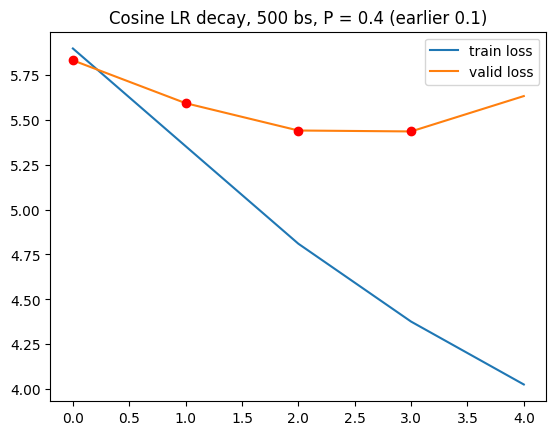

In [77]:
plt.title('Cosine LR decay, 500 bs, P = 0.4 (earlier 0.1)')
plt.plot(lossi, label='train loss')
plt.plot(vlossi, label='valid loss')

for sp in saves:
    plt.plot(sp, vlossi[sp], 'ro')  # red dots on the validation loss line

plt.legend()
plt.show()

In [78]:
model = TinyBERT()
model.load_state_dict(torch.load('./tinybert.cuda.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [235]:
context = "[CLS]tell me that I [MASK] give one of the provinces of my kingdom[SEP]"

input_ids = tkn.encode(context)
input_ids = torch.tensor(input_ids).unsqueeze(0)
attn_mask = torch.ones(input_ids.shape)

with torch.no_grad():
  logits, _ = model(input_ids, attn_mask)
  preds = logits.softmax(-1).squeeze(0)

mask_token_idx = input_ids.squeeze().tolist().index(special_tokens[MASK])

preds = preds[mask_token_idx]
token = torch.multinomial(preds, 1)
fill_mask = tkn.decode(token.tolist())

''.join([fill_mask if i == special_tokens[MASK] else tkn.decode([i]) for i in input_ids.squeeze(0).tolist()])

'[CLS]tell me that I , give one of the provinces of my kingdom[SEP]'